<a href="https://colab.research.google.com/github/poojashresthacode/23-Homework7G3/blob/seventh_config/config_seventh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import scipy.optimize

In [4]:
ke2 = 197 / 137 # eV-nm   Coulomb force charge
alpha = 1.09e3  # eV      parameter of model
rho = 0.0321    # nm      parameter of model
b = 1.0         # eV      regular
c = 0.01        # nm

In [5]:
#Helpful solution to convert itertools combinations to numpy arrays here:
## https://stackoverflow.com/questions/33282369/convert-itertools-array-into-numpy-array
def cp(l):
    return np.fromiter(itertools.chain(*itertools.combinations(l,2)),dtype=int).reshape(-1,2)

class Cluster:
    def __init__(self, r_na, r_cl):
        '''
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation.
        '''
        self.positions = np.concatenate( (r_na,r_cl))
        self.charges = np.concatenate( [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)] )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = self.charges[self.combs][:,0] * self.charges[self.combs][:,1]
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    def Vij(self):
        '''Calculate a numpy vector of all of the potentials of the combinations'''
        self.Vij_ = np.zeros_like(self.rij)
        pos = self.chargeprods>0
        neg = ~pos
        self.Vij_[pos] = ke2 / self.rij[pos] + b*(c/self.rij[pos])**12
        self.Vij_[neg] =-ke2 / self.rij[neg] + alpha*np.exp(-self.rij[neg]/rho) + b*(c/self.rij[neg])**12
        return self.Vij_

    def V(self):
        '''Total potential, which is a sum of the Vij vector'''
        return np.sum(self.Vij())

    def get_vals(self):
        '''Positions interpreted as a flat shape'''
        return np.reshape(self.positions, -1)

    def set_vals(self, vals ):
        '''Inputs flat shape of positions, used by __call__'''
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)


    def __call__(self, vals):
        '''Function that  scipy.optimize.minimize will call'''
        self.set_vals(vals)
        return self.V()

In [6]:
# Initial "ideal" configuration for Na4Cl4 tetramer
a = 0.2
r_na_ideal = np.array([[0, 0, 0], [0, 0, 2*a], [0, a, a], [0, 2*a, -0.5*a]])
r_cl_ideal = np.array([[0, 0, a], [0, a, 2*a], [a, a, 0], [a, -a, 0]])


# Create Cluster instance using ideal positions
cluster = Cluster(r_na_ideal, r_cl_ideal)
vals_init = cluster.get_vals()

print('initial Na positions:\n', r_na_ideal)
print('initial Cl positions:\n', r_cl_ideal)
print('initial positions flattened shape:\n', vals_init)
print('initial V  :', cluster.V())


initial Na positions:
 [[ 0.   0.   0. ]
 [ 0.   0.   0.4]
 [ 0.   0.2  0.2]
 [ 0.   0.4 -0.1]]
initial Cl positions:
 [[ 0.   0.   0.2]
 [ 0.   0.2  0.4]
 [ 0.2  0.2  0. ]
 [ 0.2 -0.2  0. ]]
initial positions flattened shape:
 [ 0.   0.   0.   0.   0.   0.4  0.   0.2  0.2  0.   0.4 -0.1  0.   0.
  0.2  0.   0.2  0.4  0.2  0.2  0.   0.2 -0.2  0. ]
initial V  : -18.417354969091683


In [7]:
res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

Final optimized cluster positions
[[ 0.19421003  0.0042452   0.06015449]
 [ 0.07512365 -0.27734087  0.25410086]
 [-0.09468067  0.194785    0.21432129]
 [ 0.02441364  0.47637688  0.02038706]
 [-0.01617159 -0.04496002  0.24049382]
 [-0.15771362  0.43377828  0.17650278]
 [ 0.11570388  0.24399271  0.03398245]
 [ 0.25724764 -0.23474607  0.09797901]]
Final potential: -27.729842282541327


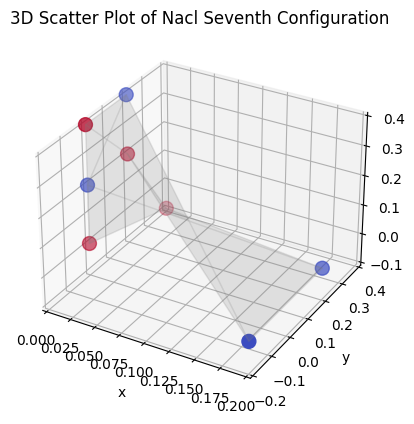

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Side length 'a' and positions for Na+ and Cl- ions
a = 0.2
r_na = np.array([[0, 0, 0], [0, 0, 2*a], [0, 2*a, -a/2], [0, a, a]])
r_cl = np.array([[0, 0, a], [0, a, 2*a], [a, a, 0], [a, -a, 0]])

# Combine Na+ and Cl- positions
vertices = np.vstack((r_na, r_cl))

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the ions
charges = np.concatenate((np.ones(len(r_na)), -np.ones(len(r_cl))))
x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
ax.scatter(x, y, z, c=charges, cmap='coolwarm', s=100)  # s is the size of the points

# Draw the shaded faces of the cube
# Each face is a polygon defined by a list of vertices
# Since the exact cube is not defined, we will assume the Na+ and Cl- ions are at the corners and edge centers
faces = Poly3DCollection([
    [vertices[0], vertices[1], vertices[3], vertices[2]],  # Bottom face
    [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face
    [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face
    [vertices[4], vertices[5], vertices[7], vertices[6]],  # Top face
    [vertices[0], vertices[2], vertices[6], vertices[4]],  # Left face
    [vertices[1], vertices[3], vertices[7], vertices[5]]   # Right face
], alpha=0.1, color='gray')  # alpha controls the transparency

# Add the faces to the plot
ax.add_collection3d(faces)

# Set labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D Scatter Plot of Nacl Seventh Configuration')


# Set limits to make the plot a perfect cube
ax.set_xlim([min(x), max(x)])
ax.set_ylim([min(y), max(y)])
ax.set_zlim([min(z), max(z)])

# Show the plot
plt.show()
